# Supervised Learning

In [53]:
import warnings
warnings.filterwarnings("ignore")

## 1. Imports and Setup

In [54]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Download NLTK assets
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/jalloh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jalloh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jalloh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [55]:
# Load the Dataset

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [56]:
df.shape

(50000, 2)

In [57]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [58]:
df.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [60]:
df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [61]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## 2. EDA

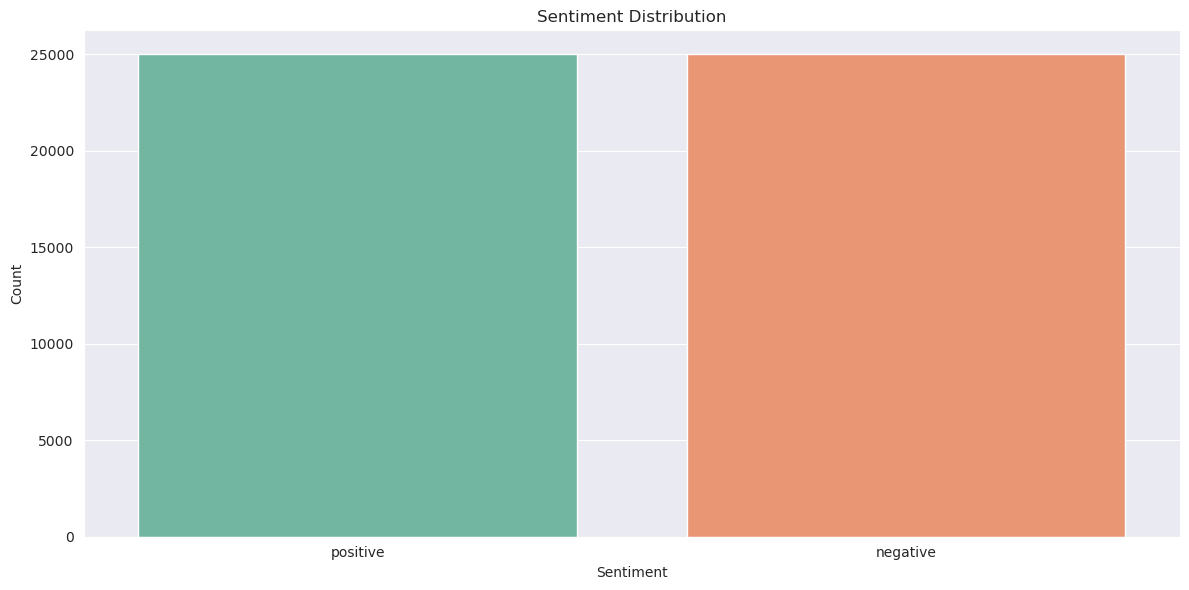

In [62]:
# Sentiment Distribution Plot

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

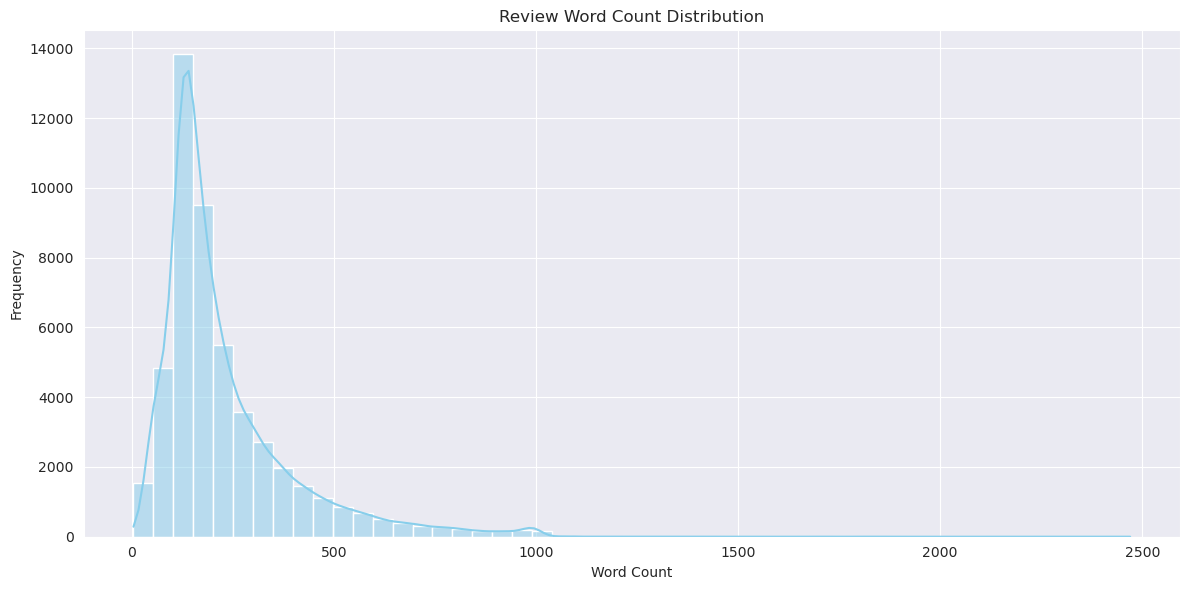

In [63]:
# Review Word Count Distribution

df['review_length'] = df['review'].apply(lambda x: len(x.split()))

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.title("Review Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 3. Preprocesssing

In [64]:
# Remove stopwords
stop_words = set(stopwords.words('english'))

#Get the root of the words
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply to your column
df['review'] = df['review'].apply(clean_text)

In [65]:
df['review'][10]

'phil alien one quirky film humour based around oddness everything rather actual punchlinesat first odd pretty funny movie progressed didnt find joke oddness funny anymoreits low budget film thats never problem pretty interesting character eventually lost interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [66]:
df.head()

,review,sentiment,review_length
0,one reviewer mentioned watching oz episode you...,positive,307
1,wonderful little production filming technique ...,positive,162
2,thought wonderful way spend time hot summer we...,positive,166
3,basically there family little boy jake think t...,negative,138
4,petter matteis love time money visually stunni...,positive,230


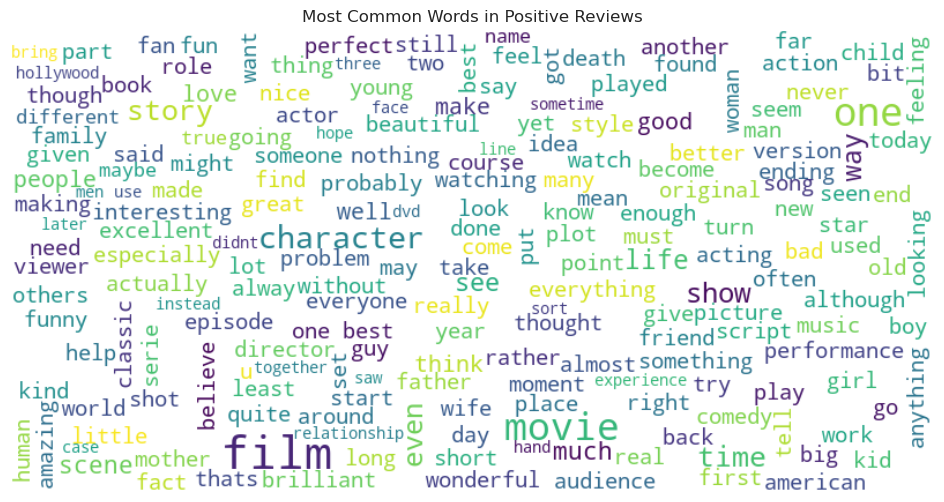

In [26]:
# WordCloud for Positive Reviews

df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

positive_text = ' '.join(df[df['label'] == 1]['review'].values)
wordcloud_pos = WordCloud(width=800,
                          height=400, 
                          background_color='white',
                         max_font_size=40).generate(positive_text)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Positive Reviews")

plt.show()

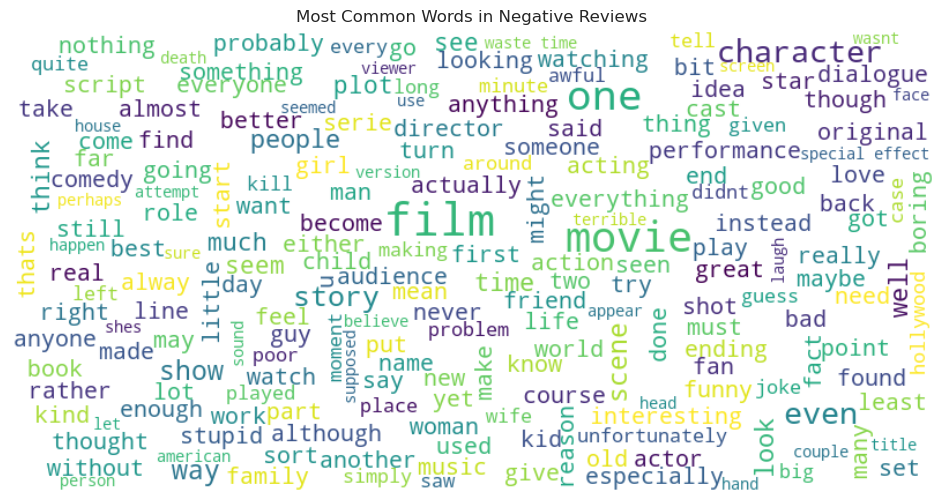

In [27]:
# 4. WordCloud for Negative Reviews

negative_text = ' '.join(df[df['label'] == 0]['review'].values)
wordcloud_neg = WordCloud(width=800,
                          height=400, 
                          background_color='white',
                         max_font_size=40).generate(negative_text)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Negative Reviews")

plt.show()

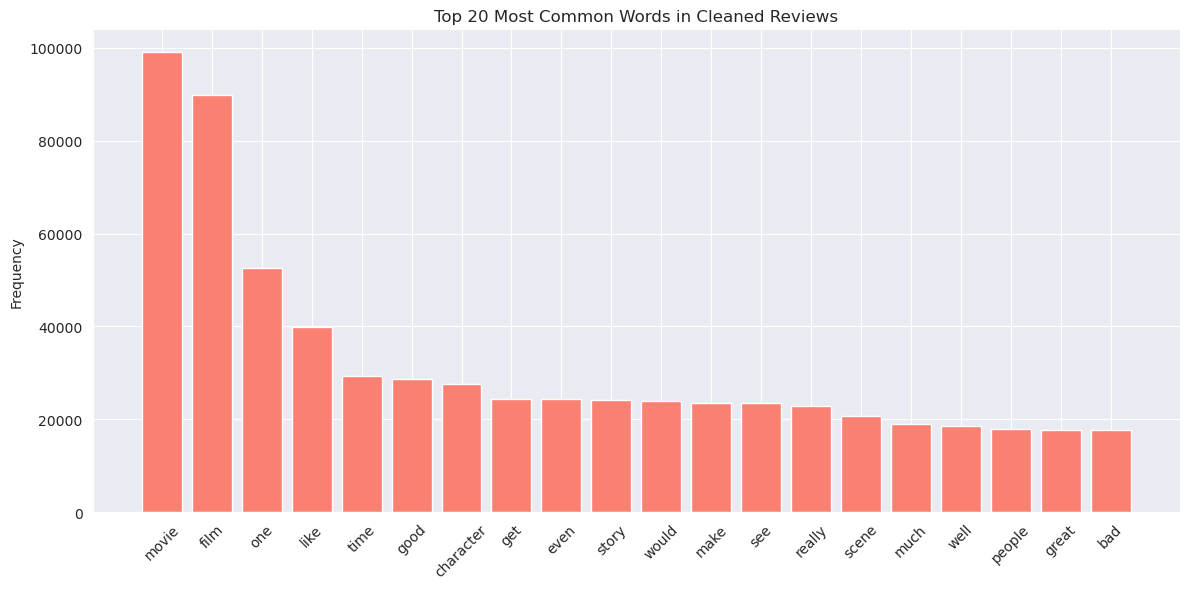

In [67]:
# Combine all words
all_words = ' '.join(df['review']).split()

# Count all
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

# Unpack for plotting
words, counts = zip(*common_words)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

plt.bar(words, counts, color='salmon')
plt.title("Top 20 Most Common Words in Cleaned Reviews")
plt.xticks(rotation=45)
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [68]:
length_reviews = df.review.str.len()

print("Max length",length_reviews.max())
print("Min length",length_reviews.min())

Max length 9182
Min length 17


In [69]:
le = LabelEncoder()

df['label'] = le.fit_transform(df['sentiment'])
df.head()

,review,sentiment,review_length,label
0,one reviewer mentioned watching oz episode you...,positive,307,1
1,wonderful little production filming technique ...,positive,162,1
2,thought wonderful way spend time hot summer we...,positive,166,1
3,basically there family little boy jake think t...,negative,138,0
4,petter matteis love time money visually stunni...,positive,230,1


## 4. TF-IDF Vectorization

In [70]:
tfidf = TfidfVectorizer(max_features=5000)

X = tfidf.fit_transform(df['review']).toarray()
y = df['label']

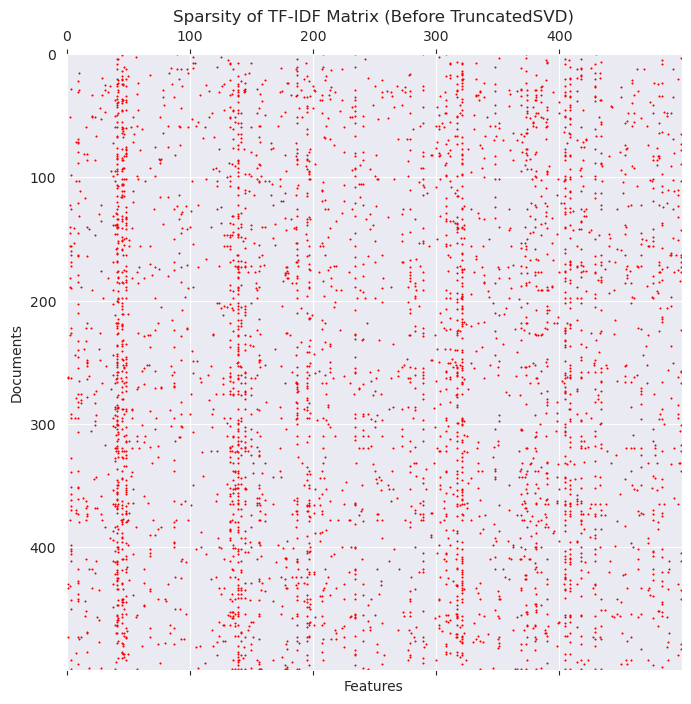

In [71]:
# Plot sparsity BEFORE TruncatedSVD

plt.figure(figsize=(8, 8))

plt.spy(X[:500, :500], markersize=0.5, color="red")
plt.title("Sparsity of TF-IDF Matrix (Before TruncatedSVD)")
plt.xlabel("Features")
plt.ylabel("Documents")

plt.show()

In [72]:
# 2. Apply TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_svd = svd.fit_transform(X)

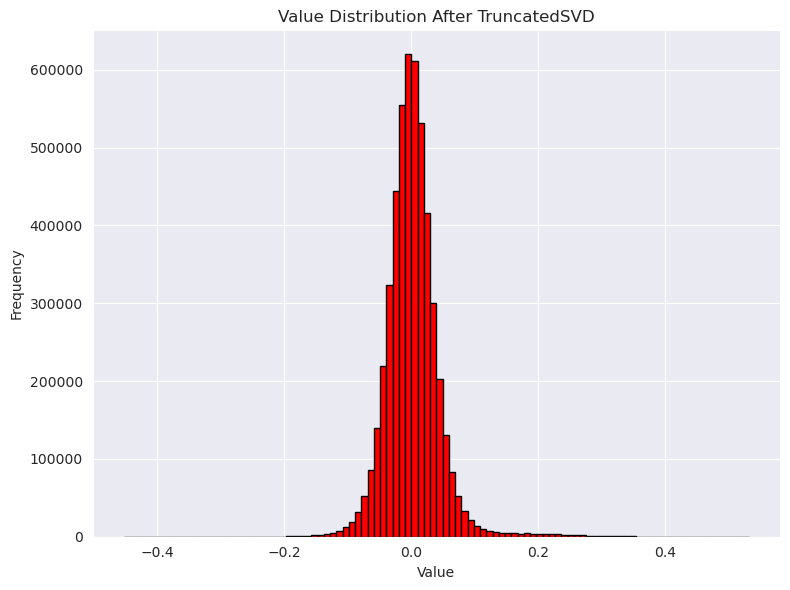

In [73]:
plt.figure(figsize=(8, 6))

plt.hist(X_svd.ravel(), bins=100, color='red', edgecolor='black')
plt.title("Value Distribution After TruncatedSVD")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 5. Split the Data to Train & Test

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    X_svd, y, test_size=0.2, stratify=y, random_state=42)


In [80]:
df['review'][10]

'phil alien one quirky film humour based around oddness everything rather actual punchlinesat first odd pretty funny movie progressed didnt find joke oddness funny anymoreits low budget film thats never problem pretty interesting character eventually lost interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [81]:
top_words = X_df.loc[0].sort_values(ascending=False).head(10)
print(top_words)

oz          0.472597
violence    0.250954
prison      0.229004
inmate      0.204510
forget      0.197168
struck      0.177178
show        0.153041
due         0.125163
city        0.122533
episode     0.112793
Name: 0, dtype: float64


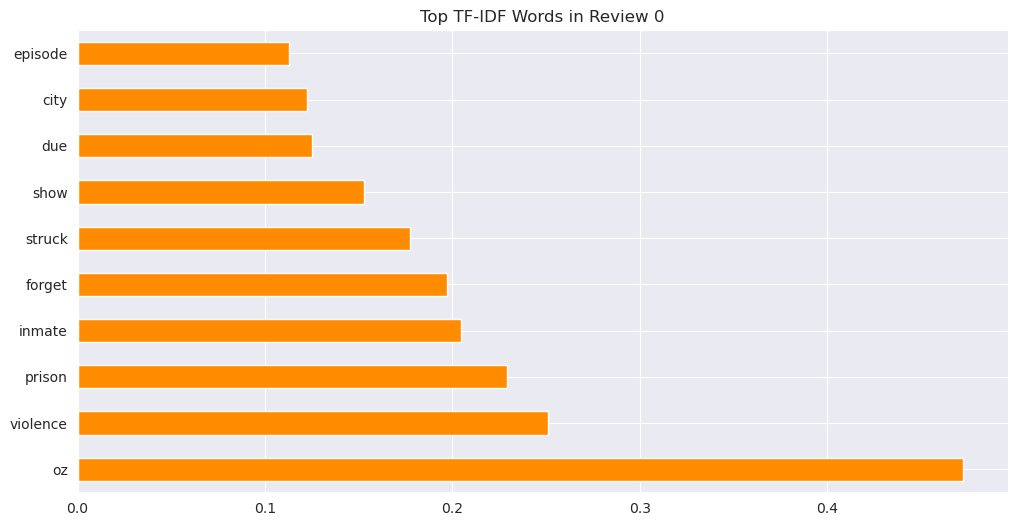

In [83]:
sns.set_style("darkgrid")
plt.figure(figsize=(12,6))

top_words.plot(kind='barh',
               title="Top TF-IDF Words in Review 0",
               color = "darkorange")

plt.show()

## 6. Modelling

### 6.1 Train 3 Simple Models


🔹 Starting training: SVM ...
Finished training: SVM
Predicting with: SVM ...
Finished prediction: SVM
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      5000
           1       0.86      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Plotting confusion matrix...


<Figure size 1200x600 with 0 Axes>

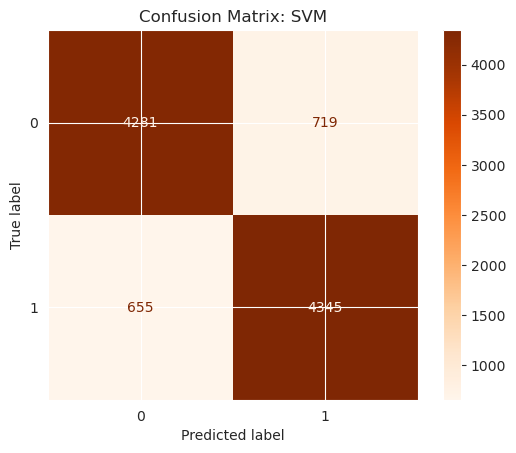


🔹 Starting training: Decision Tree ...
Finished training: Decision Tree
Predicting with: Decision Tree ...
Finished prediction: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      5000
           1       0.71      0.71      0.71      5000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

Plotting confusion matrix...


<Figure size 1200x600 with 0 Axes>

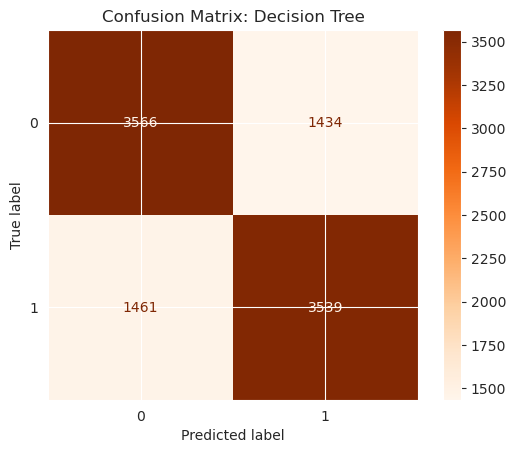


🔹 Starting training: KNN ...
Finished training: KNN
Predicting with: KNN ...
Finished prediction: KNN
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      5000
           1       0.73      0.76      0.75      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Plotting confusion matrix...


<Figure size 1200x600 with 0 Axes>

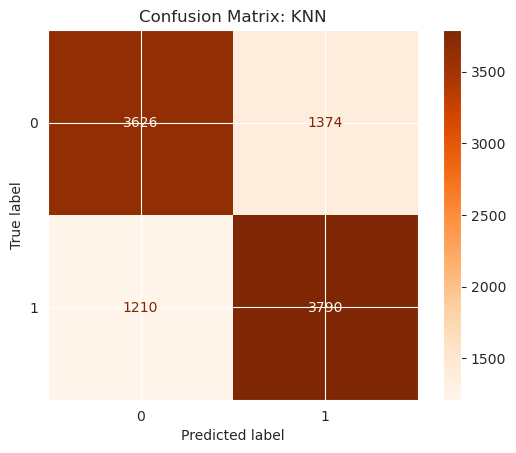

In [90]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


models = {
    "SVM": SVC(probability=False),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

for name, model in models.items():
    print(f"\n🔹 Starting training: {name} ...")
    
    model.fit(X_train, y_train)
    print(f"Finished training: {name}")

    print(f"Predicting with: {name} ...")
    y_pred = model.predict(X_test)
    print(f"Finished prediction: {name}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Plotting confusion matrix...")

    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 6))
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges', values_format='d')
    
    plt.title(f"Confusion Matrix: {name}")

    plt.show()

### 6.2 Train 3 Ensemble Models


🔹 Training Random Forest...
Random Forest completed in 43.06 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      5000
           1       0.81      0.82      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



<Figure size 800x600 with 0 Axes>

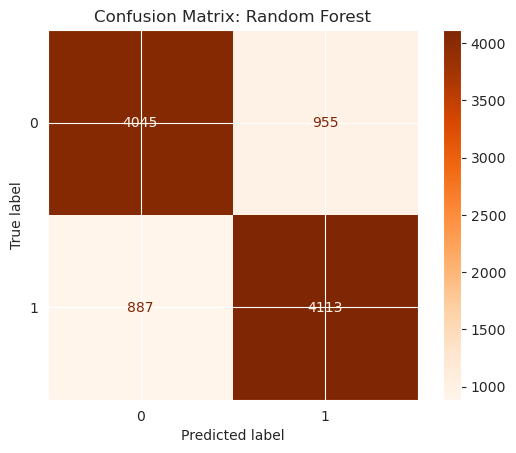


🔹 Training AdaBoost...
AdaBoost completed in 58.26 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      5000
           1       0.80      0.83      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



<Figure size 800x600 with 0 Axes>

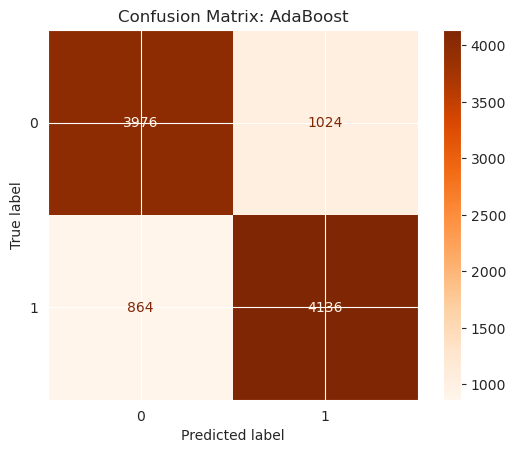


🔹 Training Gradient Boosting...
Gradient Boosting completed in 149.91 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      5000
           1       0.81      0.83      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



<Figure size 800x600 with 0 Axes>

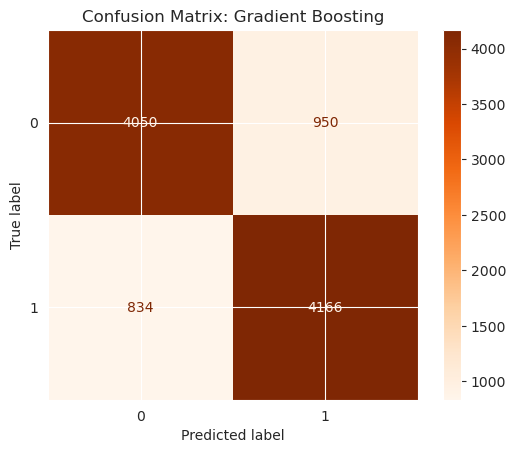

In [91]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

ensemble_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

for name, model in ensemble_models.items():
    print(f"\n🔹 Training {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    duration = time.time() - start

    print(f"{name} completed in {duration:.2f} seconds")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges', values_format='d')

    plt.title(f"Confusion Matrix: {name}")
    plt.show()


### 7. SVM Fine-Tuning: GridSearchCV

#### 7.1 Linear vs. RBF Kernel 

In [ ]:
# Define both models
svm_linear = SVC(kernel='linear', probability=False)
svm_rbf = SVC(kernel='rbf',probability=False)

# Cross-validation F1 scores
cv_linear = cross_val_score(svm_linear, X_train, y_train, cv=5, scoring='f1')
cv_rbf = cross_val_score(svm_rbf, X_train, y_train, cv=5, scoring='f1')

print("🔹 Cross-Validation Results (F1 Score)")
print(f"Linear SVM CV F1 Score: {cv_linear.mean():.4f}")
print(f"RBF SVM CV F1 Score:    {cv_rbf.mean():.4f}")

#### 7.2 Separability

In [ ]:
from sklearn.decomposition import PCA

X_vis = PCA(n_components=2).fit_transform(X_svd)

sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title(" Linear Separability)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

#### 7.3 Regularization strength : C

The tradeoff between margin size & misclassificatio

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=16.2min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=14.8min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=11.1min
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=16.1min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=16.2min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=10.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=16.4min
[CV] END .......................C=1, gamma=scale, kernel=rbf; total time=15.0min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=11.8min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=15.6min
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=10.5min
[CV] END ........................C=1, gamma=auto

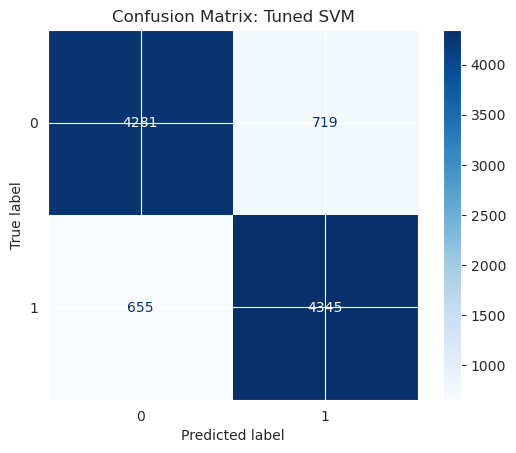

In [48]:
from sklearn.model_selection import GridSearchCV
import time

# Define efficient grid
param_grid = {
    'C': [0.1, 1, 10],
}

# Fixed RBF kernel and gamma='scale'
svm = SVC(kernel='rbf', gamma='scale')

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("Starting Grid Search with gamma='scale'...")
start = time.time()
grid_search.fit(X_train, y_train)
duration = time.time() - start

# Report best result
print(f"\nGrid Search completed in {duration:.2f} seconds")
print("Best Parameters:", grid_search.best_params_)
print(f"Best F1 Score (CV): {grid_search.best_score_:.4f}")

# Test evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Negative', 'Positive']
)

disp.plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix: Tuned SVM (RBF, gamma='scale')")

plt.show()

#### 7.4 Evaluate Best SVM Model

In [51]:
best_model = grid_search.best_estimator_

# Fit best model on full training data
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Print report
print("\nFinal Evaluation with Best SVM Model")
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Negative', 'Positive']
)
disp.plot(cmap='Oranges', values_format='d')
disp.ax_.grid(False)
for text in disp.text_:
    text.set_fontsize(14)
plt.title("Confusion Matrix: Best SVM Model")
plt.show()

Linear Kernel F1 Score: 0.8551
RBF Kernel F1 Score: 0.8602


#### 7.5 Overfitting Check

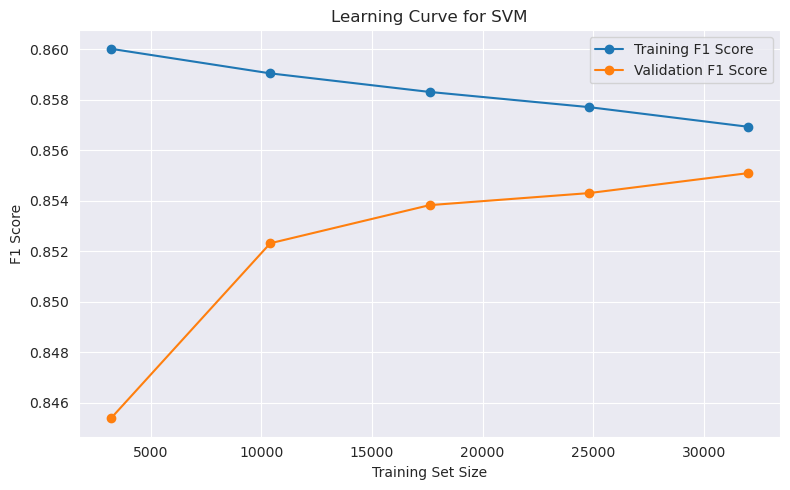

In [50]:

# Learning curve for best SVM model
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='royalblue', label='Training F1 Score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='royalblue')

plt.plot(train_sizes, val_mean, 'o-', color='darkorange', label='Validation F1 Score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='darkorange')

plt.title("Learning Curve for SVM (Best Model)")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


8. ## Train LDA Classifier

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize and train LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Predict on test set
y_pred = lda_model.predict(X_test)

# Print classification report
print("Classification Report (LDA):")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=['Negative', 'Positive']
)
disp.plot(cmap='Purples', values_format='d')

plt.title("Confusion Matrix: LDA Model")
plt.show()


In [ ]:
## Ty Logistic Regression and Bayes

# <center> **END** </center>